In [1]:
#------ manually fix import for now
import sys
sys.path.append('..')
#------

import numpy as np
import astropy.units as u
from redexo import *
import matplotlib.pyplot as plt
import copy

Loading 44 files...


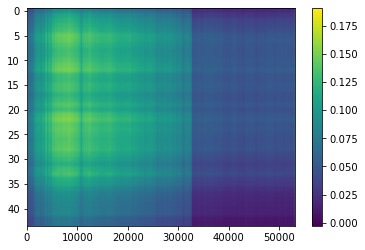

In [2]:
dataset = load_carmenes_data(folder='/users/ricolandman/Documents/Research/OH_exoplanets/Data/Wasp76_NIR/',\
                            spectral_orders=[0,1,2,3,4,5,6,7,23,24,25,26,27])

plt.imshow(dataset.spec.reshape(dataset.num_exposures,-1),aspect='auto')
plt.colorbar()
plt.show()

In [3]:
planet = Planet(Kp=196, vsys=-1.1, T0=2458080.626165, orbital_period=1.809886)
planet.transit_start = 0.045

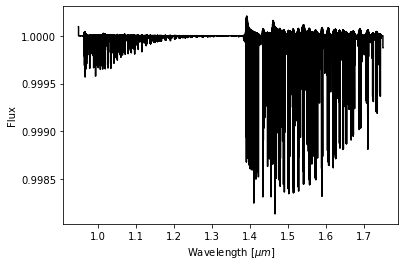

In [12]:
template_wl, template = np.load('/users/ricolandman/Documents/Research/OH_exoplanets/Data/models/Wasp76_OH_equilibrium_T=2150K_prepared.npy')
plt.plot(template_wl/1e4, template, color='black')
plt.xlabel(r'Wavelength [$\mu m$]')
plt.ylabel('Flux')
plt.show()

In [17]:
pipeline = Pipeline()

inject_planet = copy.deepcopy(planet)
inject_planet.vsys = +100

pipeline.add_module( InjectSignalModule(template=template, template_wl=template_wl, 
                                        target=inject_planet, name='injection', amplification=1.) )
pipeline.add_module( FlagAbsorptionEmissionModule(flux_lower_limit=0.4, flux_upper_limit=1.1, 
                                                    relative_to_continuum=True) )

pipeline.add_module( PolynomialContinuumRemovalModule(poly_order=3, name='cleaned'))
pipeline.add_module( OutlierFlaggingModule(sigma=5, name='cleaned') )


sysrem = SysRemModule(number_of_modes=6, mode='subtract', name='sysrem') 
#sysrem = PCASubtractModule(number_of_modes=6,name='sysrem') 
pipeline.add_module(sysrem)

pipeline.add_module( CrossCorrelationModule(template = template, template_wl = template_wl, 
                                            rv_range=300, drv=1.3, error_weighted=True))
pipeline.add_module( CoAddOrders(name='co_added', weights=None))
pipeline.add_module( ShiftRestFrameModule(target=inject_planet, name='CCF_map_planet'))
pipeline.add_module( CoAddExposures(name='1D_CCF', weights=planet.in_transit(dataset.obstimes)))

In [18]:
pipeline2 = Pipeline()

pipeline2.add_module( FlagAbsorptionEmissionModule(flux_lower_limit=0.4, flux_upper_limit=1.1, 
                                                    relative_to_continuum=True) )

pipeline2.add_module( PolynomialContinuumRemovalModule(poly_order=3, name='cleaned'))
pipeline2.add_module( OutlierFlaggingModule(sigma=5, name='cleaned') )


sysrem2 = SysRemModule(number_of_modes=6, mode='subtract', name='sysrem') 
#sysrem = PCASubtractModule(number_of_modes=6,name='sysrem') 
pipeline2.add_module(sysrem)

pipeline2.add_module( CrossCorrelationModule(template = template, template_wl = template_wl, 
                                            rv_range=300, drv=1.3, error_weighted=True))
pipeline2.add_module( CoAddOrders(name='co_added', weights=None))
pipeline2.add_module( ShiftRestFrameModule(target=planet, name='CCF_map_planet'))
pipeline2.add_module( CoAddExposures(name='1D_CCF', weights=planet.in_transit(dataset.obstimes)))

In [19]:
snrs = []
snrs_true = []
sysrem_modes = np.arange(2,20)
for sysrem_it in sysrem_modes:
    sysrem.number_of_modes = sysrem_it
    sysrem2.number_of_modes = sysrem
    pipeline.run(copy.deepcopy(dataset), num_workers=7, per_order=True)
    pipeline2.run(copy.deepcopy(dataset),num_workers=7, per_order=True)
    
    ccf_inj = pipeline.get_results('1D_CCF').normalize().spec
    snr_inj = ccf_inj[0,:, ccf_inj.shape[-1]//2]
    snrs.append(snr_inj)
    
    ccf_map_earth = pipeline2.get_results('co_added')
    Kp_list = np.arange(180,350, 1.3)
    snr_map = make_kp_vsys_map(ccf_map_earth, Kp_list, planet)
    '''
    plt.imshow(snr_map,aspect='auto',origin='lower', extent=[np.min(ccf_map_earth.rv_grid), 
                            np.max(ccf_map_earth.rv_grid), min(Kp_list), max(Kp_list)], cmap='gist_heat')
    plt.colorbar()
    plt.show()
    plt.imshow(snr_map[:,np.abs(ccf_map_earth.rv_grid[0,0])<50],aspect='auto',origin='lower', extent=[-50,50,
                                                                min(Kp_list), max(Kp_list)], cmap='gist_heat')
    plt.colorbar()
    plt.show()
    '''
    
    snr = np.max(snr_map[:,np.abs(ccf_map_earth.rv_grid[0,0])<50])
    snrs_true.append(snr)
    print('Sysrem iterations:',sysrem_it,snrs[-1], snrs_true[-1])
    

Sysrem iterations: 2 [6.44898562] 2.8139614138353637
Sysrem iterations: 3 [6.08806553] 3.0736286791090897
Sysrem iterations: 4 [6.63180036] 5.27956769387553
Sysrem iterations: 5 [7.87639848] 5.594409678025697
Sysrem iterations: 6 [7.95675858] 5.702911413609991
Sysrem iterations: 7 [8.05818353] 5.295485489067931
Sysrem iterations: 8 [8.23297193] 5.449978096223037
Sysrem iterations: 9 [8.40113637] 5.201454988602443
Sysrem iterations: 10 [8.45391103] 5.478322521023294
Sysrem iterations: 11 [8.70053922] 5.526483773306795
Sysrem iterations: 12 [9.0515296] 5.40457319018244
Sysrem iterations: 13 [9.30611845] 5.261947487761734
Sysrem iterations: 14 [8.95272694] 5.334498177927684
Sysrem iterations: 15 [8.6340894] 4.989841059455201


Process ForkPoolWorker-14:
Process ForkPoolWorker-15:
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

Process ForkPoolWorker-13:
Process ForkPoolWorker-11:
Process ForkPoolWorker-9:
Process ForkPoolWorker-10:
Process ForkPoolWorker-12:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/ricolandman/miniforge3/envs/mypython/lib/python3.9/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/ricolandman/miniforge3/envs/mypython/lib/python3.9/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/ricolandman/miniforge3/envs/mypython/lib/python3.9/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/ricolandman

Traceback (most recent call last):
  File "/Users/ricolandman/miniforge3/envs/mypython/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3418, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-19-3db0865c1a24>", line 8, in <module>
    pipeline2.run(copy.deepcopy(dataset),num_workers=7, per_order=True)
  File "../redexo/core/pipeline.py", line 53, in run
    results = p.map(lambda order: module.process(processed_dataset.get_order(order), order, debug=debug), range(processed_dataset.num_orders))
  File "/Users/ricolandman/miniforge3/envs/mypython/lib/python3.9/site-packages/pathos/multiprocessing.py", line 137, in map
    return _pool.map(star(f), zip(*args)) # chunksize
  File "/Users/ricolandman/miniforge3/envs/mypython/lib/python3.9/site-packages/multiprocess/pool.py", line 364, in map
    return self._map_async(func, iterable, mapstar, chunksize).get()
  File "/Users/ricolandman/miniforge3/envs/mypython/lib/python3.9/site-pack

TypeError: object of type 'NoneType' has no len()

Process ForkPoolWorker-23:
Process ForkPoolWorker-20:
Process ForkPoolWorker-21:
Process ForkPoolWorker-22:
Process ForkPoolWorker-18:
Process ForkPoolWorker-17:
Process ForkPoolWorker-19:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/ricolandman/miniforge3/envs/mypython/lib/python3.9/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/ricolandman/miniforge3/envs/mypython/lib/python3.9/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/ricolandman/miniforge3/envs/mypython/lib/python3.9/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/ricolandman/miniforge3/envs/mypython/lib/python3.9/site-packages/multiprocess/process.py", line 315, in _bootstrap
 

In [ ]:
plt.plot(sysrem_modes,snrs, label='Injected')
plt.plot(sysrem_modes, snrs_true, label='Real')
plt.show()

In [10]:
pipeline2 = Pipeline()

pipeline2.add_module( FlagAbsorptionEmissionModule(flux_lower_limit=0.4, flux_upper_limit=1.1, 
                                                    relative_to_continuum=True) )

pipeline2.add_module( PolynomialContinuumRemovalModule(poly_order=3))
pipeline.add_module( OutlierFlaggingModule(sigma=5) )

pipeline2.add_module(SysRemModule(number_of_modes=9, mode='subtract', name='cleaned') )

pipeline2.add_module( CrossCorrelationModule(template = template, template_wl = template_wl, 
                                            rv_range=300, drv=1.3, error_weighted=False))
pipeline2.add_module( CoAddOrders(name='co_added', weights=None))
pipeline2.add_module( ShiftRestFrameModule(target=planet, name='CCF_map_planet'))
pipeline2.add_module( CoAddExposures(name='1D_CCF', weights=planet.in_transit(dataset.obstimes)))

(44, 1, 462)
SNR: 4.685121579753836


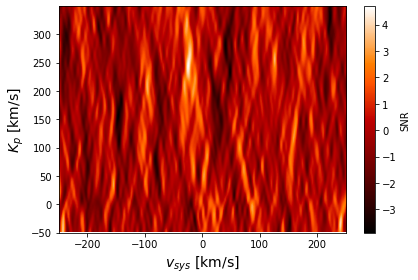

In [11]:
Kp_list = np.arange(-50,350, 1.3)
pipeline2.run(dataset, num_workers=7, per_order=True)
ccf_map_earth = pipeline2.get_results('co_added')

print(ccf_map_earth.spec.shape)
snr_map = make_kp_vsys_map(ccf_map_earth, Kp_list, planet)

plt.imshow(snr_map, origin='lower', cmap='gist_heat', aspect='auto', 
           extent=[np.min(ccf_map_earth.rv_grid), np.max(ccf_map_earth.rv_grid), min(Kp_list), max(Kp_list)])
plt.ylabel(r'$K_p$ [km/s]', fontsize=14)
plt.xlabel(r'$v_{sys}$ [km/s]',fontsize=14)
plt.xlim(-250,250)
plt.colorbar(label='SNR')
plt.tight_layout()
print('SNR:', np.max(snr_map))